### Imports 

In [1]:
#for dealing with data:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import xarray as xr

#for dealing with files:
import os
import re
from scipy.io import readsav
import h5py
import requests
from bs4 import BeautifulSoup
from tqdm import tqdm
from urllib.parse import urljoin, urlparse
import time

#for plotting (the rcParams updates are my personal perference to change font and increase fontsize)
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 24,\
                     'xtick.labelsize' : 24,\
                     'ytick.labelsize' : 24,\
                     'axes.titlesize' : 24,\
                     'axes.labelsize' : 24,\
                     'date.autoformatter.minute': '%H:%M' })

# all helper functions for downloading and parsing data
import skymap_data_helper

# for contrast adjustment
import cv2

# for resolution increase
from PIL import Image

import importlib
importlib.reload(skymap_data_helper)

import math

import importlib
importlib.reload(skymap_data_helper)



#data_yknf = readsav("./trex-rgb-asi_data/rgb_skymap_yknf_20240829-%2B_v01.sav", verbose=False)['skymap']
#data_fsmi = readsav("./trex-rgb-asi_data/rgb_skymap_fsmi_20240808-%2B_v01.sav", verbose=False)['skymap']




<module 'skymap_data_helper' from '/home/molidae/Desktop/berkeley/ssl/skymap_data_helper.py'>

### Loading Data

In [2]:
#load an hour of data
site_yknf = 'yknf'
site_fsmi = 'fsmi'
date = datetime(2024,8,30)
hour = 5 #this is in UT

rgb_asi_skymap_lookup_df = skymap_data_helper.build_rgb_asi_skymap_lookup_table(directory='./trex-rgb-asi_data') #CHANGE TO YOUR SKYMAP DIRECTORY!
yknf_rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site_yknf, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!
fsmi_rgb_asi_ds = skymap_data_helper.load_rgb_asi_hour_to_xarray(site_fsmi, date, hour, rgb_asi_skymap_lookup_df,data_dir='./trex-rgb-asi_data', skymap_dir='./trex-rgb-asi_data') #CHANGE DIRECTORIES!


Skymap file:
rgb_skymap_yknf_20240829-%2B_v01.sav
skymap path:
./trex-rgb-asi_data/rgb_skymap_yknf_20240829-%2B_v01.sav
Skymap file:
rgb_skymap_fsmi_20240808-%2B_v01.sav
skymap path:
./trex-rgb-asi_data/rgb_skymap_fsmi_20240808-%2B_v01.sav


### Projecting pixels to some lat/lon

In [88]:
def project_lat_lon(az_arr, el_arr, lat_camera, lon_camera, h, skymap_110_mask):
    '''
    params: 
    az_arr = 2D azimuth array for each pixel (NaNs ok, degrees, xarray)
    el_arr = 2D elevation array for each pixel (NaNs ok, degrees, xarray, no need to be filtered)
    lat_camera = latitude of camera (degrees) --> shape [480, 553]
    lon_camera = longitude of camera (degrees) --> shape [480, 553]
    h = height you want to project azimuth and elevation to to get latitude and longitude for each pixel
    skymap_110_mask = mask for where the latitude and longitude are NaNs in the ground truth lat110 and lon110 projections

    returns: 
    lat_aurora_arr = latitudes of the aurora projected to given height h
    lon_aurora_arr = longitudes of the aurora project to give height h 
    '''

    # convert to radians + applying mask 
    el_arr = np.radians(np.array(el_arr))
    az_arr = np.radians(np.array(az_arr))
    
    # create elevation mask (True when valid)
    el_mask = (el_arr > np.radians(5)) & (el_arr < np.radians(90))
    
    # combine with skymap mask: True = valid pixel
    valid_mask = el_mask & (~skymap_110_mask)
    
    # set invalid pixels to NaN
    el_arr[~valid_mask] = np.nan
    
    # Sanity check
    # print(f"Az: {az_arr.shape}")
    # print(f"El: {el_arr.shape}")
    
    # horizontal distance between camera and aurora along camera's tangent plane
    d1_arr = h / np.tan(el_arr)

    # decompose horizontal distance into east and north components relative to camera tan plane
    dx_arr = d1_arr * np.sin(az_arr)
    dy_arr = d1_arr * np.cos(az_arr)

    # convert N/E offset components to (lat, lon) --> comes out in decimal degrees 
    lat_delta_arr = dy_arr / 111045 #degrees
    lon_delta_arr = dx_arr / (np.cos(np.radians(lat_camera + lat_delta_arr)) * 111321) 

    # add lat/long offset to camera's og lat/lon to get the lat/lon of the aurora at the chosen height!
    lat_aurora_arr = lat_camera + lat_delta_arr
    lon_aurora_arr = lon_camera + lon_delta_arr

    # restrict the latitude and longitude arrays by removing the first row / col
    #lat_aurora_arr_restricted = lat_aurora_arr[1:, 1:]
    #lon_aurora_arr_restricted = lon_aurora_arr[1:, 1:]

    # apply the same mask again just in case 
    #mask_restricted = skymap_110_mask[1:, 1:]
    lat_aurora_arr[skymap_110_mask] = np.nan
    lon_aurora_arr[skymap_110_mask] = np.nan


    
    #print(f"lat proj: {lat_aurora_arr.shape}")
    #print(f"lon proj: {lon_aurora_arr.shape}")

    return lat_aurora_arr, lon_aurora_arr

In [89]:
h_target = 110000 
lat_yknf = yknf_rgb_asi_ds.attrs["site_latitude"]
lon_yknf = yknf_rgb_asi_ds.attrs["site_longitude"]
full_elevation_yknf = yknf_rgb_asi_ds["elevation"]
full_azimuth_yknf = yknf_rgb_asi_ds["azimuth"]

full_yknf_lat110 = np.array(yknf_rgb_asi_ds.lat_110)
full_yknf_lon110 = np.array(yknf_rgb_asi_ds.lon_110)
yknf_110_mask = np.isnan(full_yknf_lat110) | np.isnan(full_yknf_lon110) # apply this mask to all frames across all elevations for YKNF


lat_proj_110_arr, lon_proj_110_arr = project_lat_lon(full_azimuth_yknf, 
                                                 full_elevation_yknf,
                                                 lat_yknf,
                                                 lon_yknf,
                                                 h_target,
                                                 yknf_110_mask
                                                )


    # ds_all.attrs["site_latitude"] = skymap["site_lat"]
    # ds_all.attrs["site_longitude"] = skymap["site_lon"]
    # ds_all.attrs["site_altitude_m"] = skymap["site_alt"]
    # ds_all.attrs["skymap_file"] = skymap_file

    # ds_all["elevation"] = (("x", "y"), skymap["elevation"])
    # ds_all["azimuth"] = (("x", "y"), skymap["azimuth"])
    # ds_all["lat_110"] = (("x", "y"), skymap["map_latitude"][1,1:,1:])
    # ds_all["lon_110"] = (("x", "y"), skymap["map_longitude"][1,1:,1:])



In [90]:
lat_110_arr = np.array(yknf_rgb_asi_ds["lat_110"])
lon_110_arr = np.array(yknf_rgb_asi_ds["lon_110"])

print(f"lat 110: {lat_110_arr.shape}")
print(f"lon 110: {lon_110_arr.shape}")

lat 110: (480, 553)
lon 110: (480, 553)


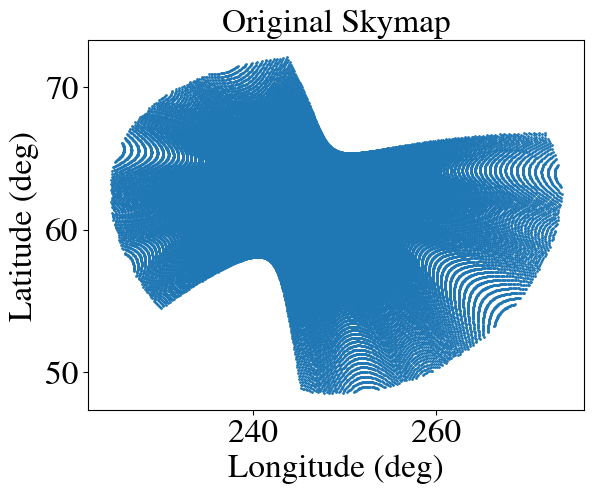

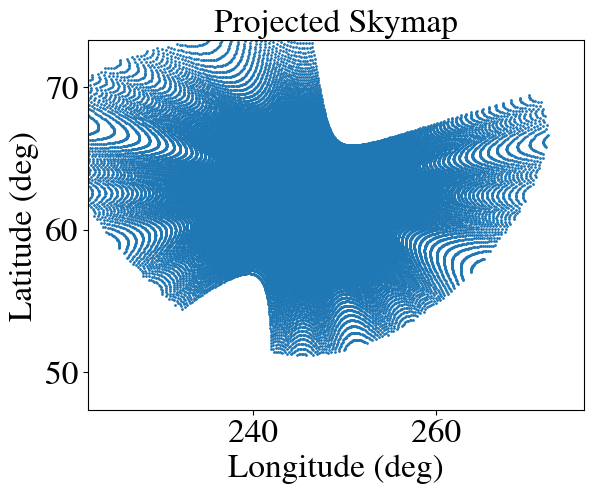

In [91]:
# original skymap
plt.figure()
plt.scatter(lon_110_arr.flatten(), lat_110_arr.flatten(), s=1, label="True Skymap")
#plt.legend()
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Original Skymap")
# plt.xlim(45, 75)
# plt.ylim(230, 270)
ax_skymap = plt.gca()
# print("X-axis limits:", ax.get_xlim())
# print("Y-axis limits:", ax.get_ylim())
plt.show()

# projected skymap
plt.figure()
plt.scatter(lon_proj_110_arr.flatten(), lat_proj_110_arr.flatten(), s=1, label="Projected to 110")
#plt.legend()
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Projected Skymap")
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()


### Overlaid Graph

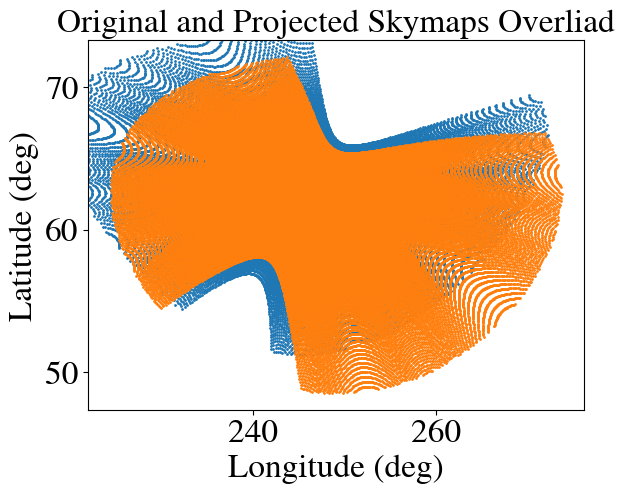

In [92]:
# original skymap
plt.figure()
plt.scatter(lon_proj_110_arr.flatten(), lat_proj_110_arr.flatten(), s=1, label="Projected to 110")
plt.scatter(lon_110_arr.flatten(), lat_110_arr.flatten(), s=1, label="True Skymap")

plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title("Original and Projected Skymaps Overliad")
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()

# check azimuth, elevation cutoff (mine is not restricted) 
# look at individual pixels near the center --> check rotation 
# static num for latitude error 

### Overlaying Pixels -- Difference between skymap and my projection
- try one frame
- try averaging a few frames --> do time slices over the entire hour

(480, 553, 3)


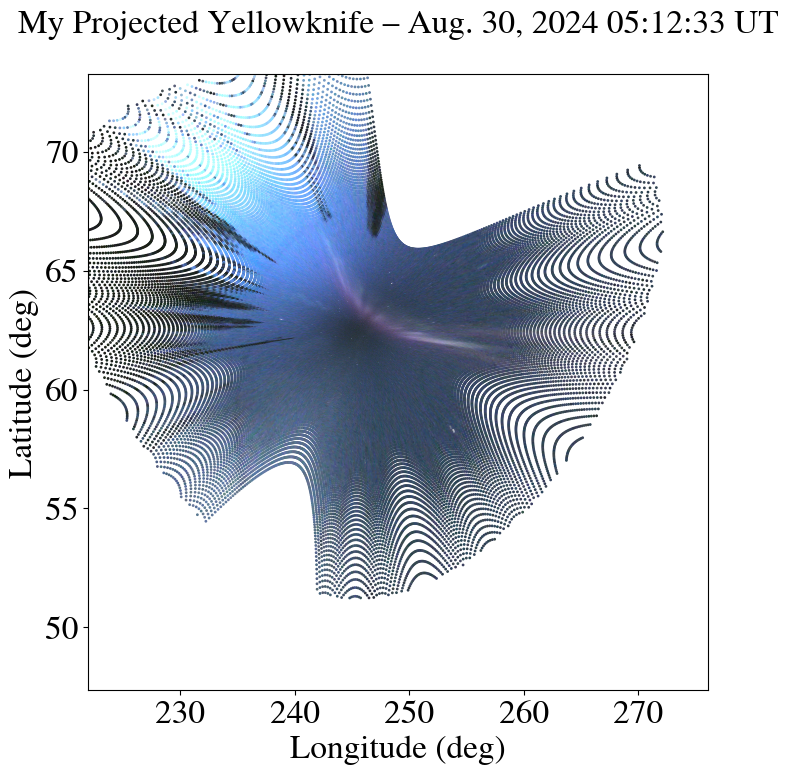

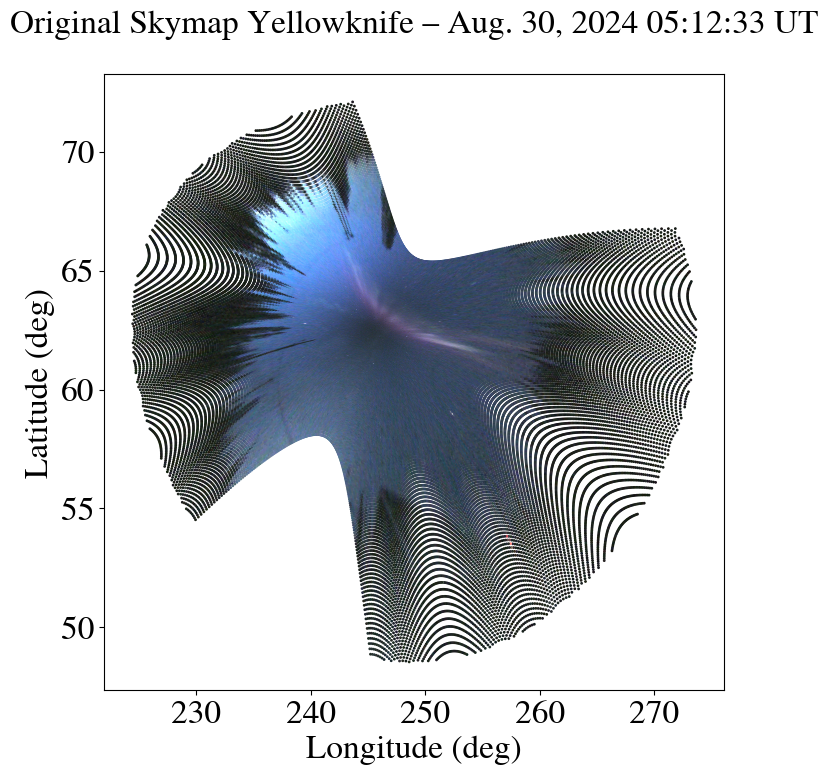

In [94]:
time_index = 251 # look at 5:10 UTC

R = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
#RGB = yknf_rgb_asi_ds.image.isel(times=time_index).values

# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

# Site label - can adjust to allow for different sites!
site_name_yknf = "Yellowknife" ## CHANGE FOR DIFF SITE
site_name_yknf_short = "yknf" ## CHANGE FOR DIFF SITE

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb = np.stack([R, G, B], axis=-1)  # shape: (x, y, 3)
rgb_yknf_adjusted = cv2.convertScaleAbs(rgb, alpha=alpha, beta=beta)
#rgb_yknf_adjusted = rgb_yknf_adjusted[yknf_110_mask].reshape(-1, 3) # needed for after masking done on az/el & projected lat/lon
print(rgb_yknf_adjusted.shape)

# yknf projected
fig1, ax1 = plt.subplots(figsize=(8,8))
scat = ax1.scatter(lon_proj_110_arr.flatten(),lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax1.set_ylabel("Latitude (deg)")
ax1.set_xlabel("Longitude (deg)")
ax1.set_title(f"My Projected {site_name_yknf} – {time_str}", pad=30);
plt.show()

# yknf given skymap
fig2, ax2 = plt.subplots(figsize=(8,8))
scat = ax2.scatter(lon_110_arr.flatten(),lat_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"Original Skymap {site_name_yknf} – {time_str}", pad=30);
plt.show()


### Error Calculations
- difference between the true skymaps and my projected skymaps
- can't do this bc my projections based on el/az, which has diff shape than the lat110/lon110 given in the skymap

In [95]:
# # remove NaNs
# lat_mask_true_skymap = ~np.isnan(lat_110_arr) 
# lat_mask_proj_skymap = ~np.isnan(lat_proj_110_arr)
# lon_mask_true_skymap = ~np.isnan(lat_110_arr) 
# lon_mask_proj_skymap = ~np.isnan(lat_proj_110_arr) 

# combined_mask = lat_mask_true_skymap & lat_mask_proj_skymap

# lat_110_arr_masked = np.array(np.where(lat_mask_true_skymap & lat_mask_proj_skymap))
# lat_proj_110_arr_masked = np.array(np.where(lat_mask_true_skymap & lat_mask_proj_skymap))
# lon_110_arr_masked = np.array(np.where(lon_mask_true_skymap & lon_mask_proj_skymap))
# lon_proj_110_arr_masked = np.array(np.where(lon_mask_true_skymap & lon_mask_proj_skymap))


# # get difference in distance, m (hence scaling) 
# north_err = (lat_proj_110_arr_masked - lat_110_arr_masked) * 111045
# east_err = (lon_proj_110_arr_masked - lon_110_arr_masked) * np.cos(np.radians(lat_proj_110_arr_masked)) * 111321

# total_err = np.sqrt(north_err**2, east_err**2) # array of per-pix error
# print(total_err)

# mean_err = np.mean(total_err)
# rms_err = np.sqrt(np.mean(total_err**2))
# max_err = np.max(total_err)

# print(f"Mean error: {mean_err:.1f} m")
# print(f"RMS error:  {rms_err:.1f} m")
# print(f"Max error:  {max_err:.1f} m")

### 110km Projected Comparisons b/w YKNF and FSMI

In [97]:
h_target = 110000 

lat_yknf = yknf_rgb_asi_ds.attrs["site_latitude"]
lon_yknf = yknf_rgb_asi_ds.attrs["site_longitude"]
full_elevation_yknf = yknf_rgb_asi_ds["elevation"]
full_azimuth_yknf = yknf_rgb_asi_ds["azimuth"]

full_yknf_lat110 = np.array(yknf_rgb_asi_ds.lat_110)
full_yknf_lon110 = np.array(yknf_rgb_asi_ds.lon_110)
yknf_110_mask = np.isnan(full_yknf_lat110) | np.isnan(full_yknf_lon110) # apply this mask to all frames across all elevations for YKNF


lat_fsmi = fsmi_rgb_asi_ds.attrs["site_latitude"]
lon_fsmi = fsmi_rgb_asi_ds.attrs["site_longitude"]
full_elevation_fsmi = fsmi_rgb_asi_ds["elevation"]
full_azimuth_fsmi = fsmi_rgb_asi_ds["azimuth"]

full_fsmi_lat110 = np.array(fsmi_rgb_asi_ds.lat_110)
full_fsmi_lon110 = np.array(fsmi_rgb_asi_ds.lon_110)
fsmi_110_mask = np.isnan(full_fsmi_lat110) | np.isnan(full_fsmi_lon110) # apply this mask to all frames across all elevations for YKNF


yknf_lat_proj_110_arr, yknf_lon_proj_110_arr = project_lat_lon(full_azimuth_yknf, 
                                                 full_elevation_yknf,
                                                 lat_yknf,
                                                 lon_yknf,
                                                 h_target,
                                                 yknf_110_mask
                                                )

fsmi_lat_proj_110_arr, fsmi_lon_proj_110_arr = project_lat_lon(full_azimuth_fsmi, 
                                                 full_elevation_fsmi,
                                                 lat_fsmi,
                                                 lon_fsmi,
                                                 h_target,
                                                 fsmi_110_mask
                                                )

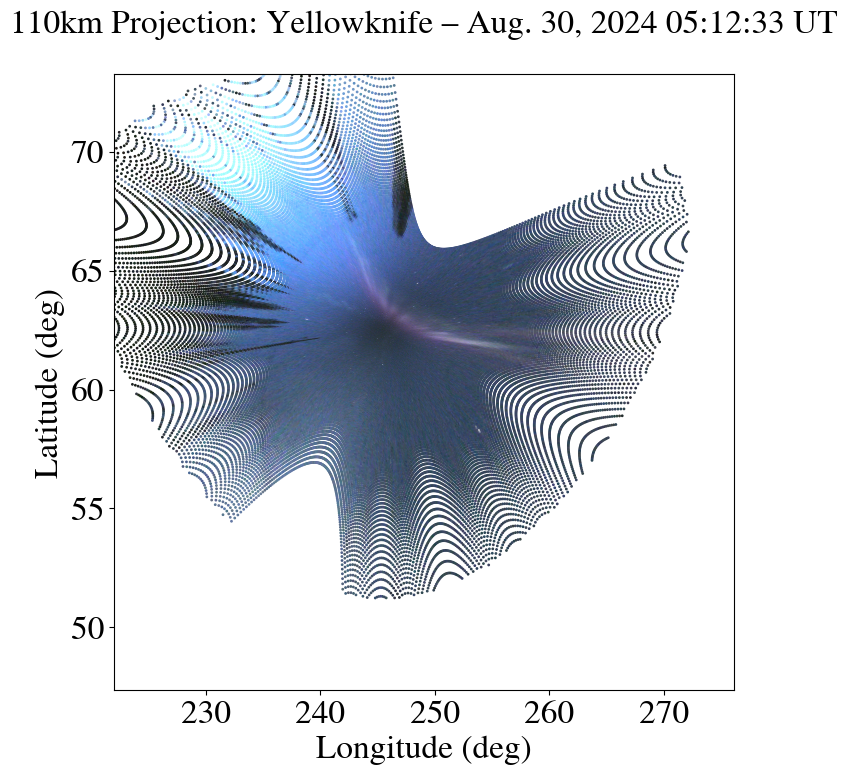

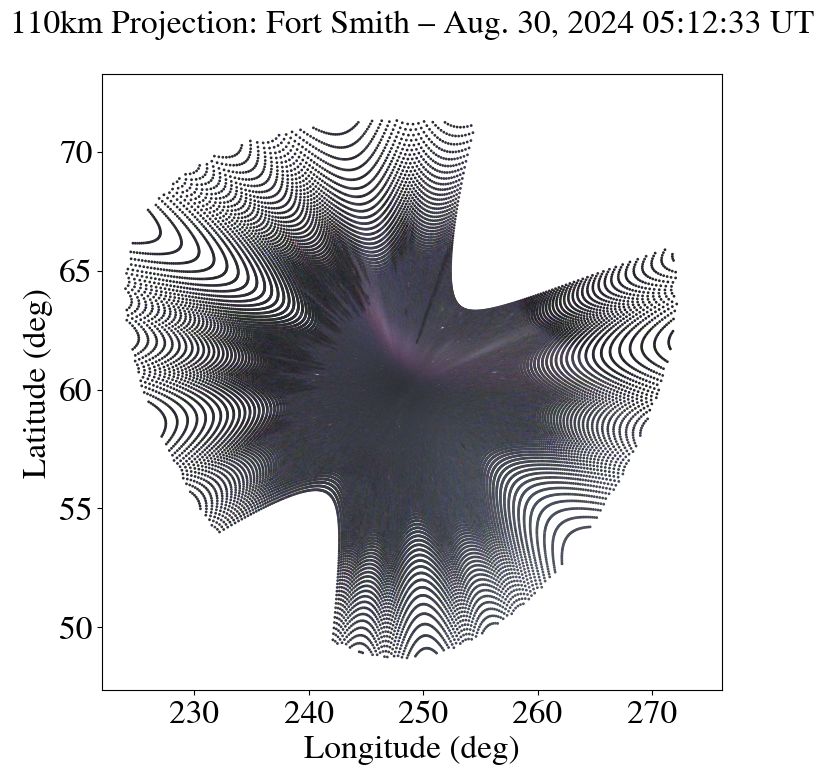

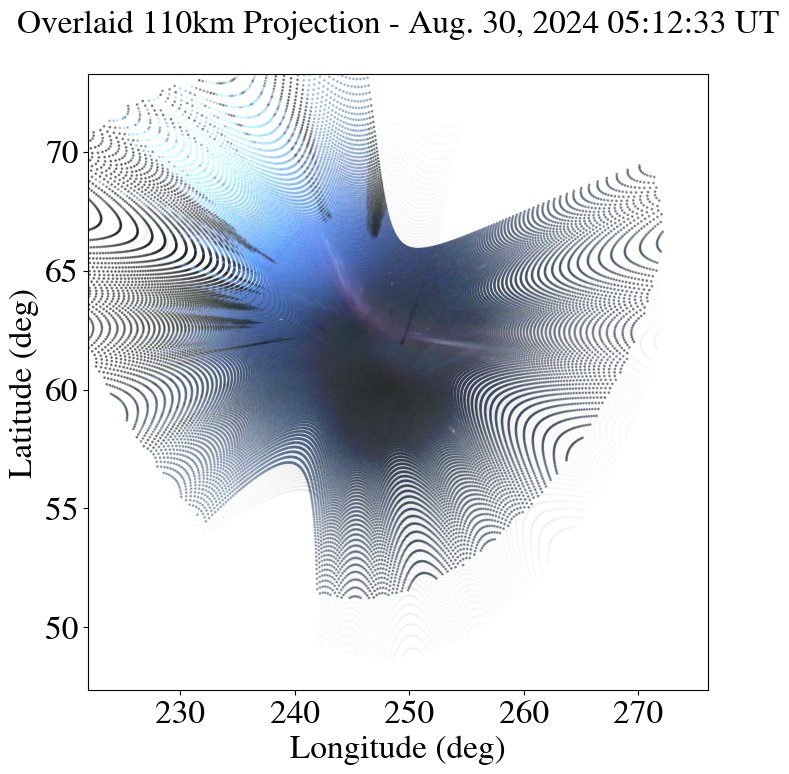

In [100]:
time_index = 251 # look at 5:10 UTC

R_yknf = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_yknf = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_yknf = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

R_fsmi = fsmi_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_fsmi = fsmi_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_fsmi = fsmi_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values


# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

site_name_yknf = "Yellowknife" 
site_name_fsmi = "Fort Smith" 

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb_yknf = np.stack([R_yknf, G_yknf, B_yknf], axis=-1)  # shape: (x, y, 3)
rgb_fsmi = np.stack([R_fsmi, G_fsmi, B_fsmi], axis=-1)  # shape: (x, y, 3)

rgb_yknf_adjusted = cv2.convertScaleAbs(rgb_yknf, alpha=alpha, beta=beta)
rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb_fsmi, alpha=alpha, beta=beta)

# yknf projected
fig1, ax1 = plt.subplots(figsize=(8,8))
scat1 = ax1.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax1.set_ylabel("Latitude (deg)")
ax1.set_xlabel("Longitude (deg)")
ax1.set_title(f"110km Projection: {site_name_yknf} – {time_str}", pad=30);
plt.show()

# fsmi projected
fig2, ax2 = plt.subplots(figsize=(8,8))
scat2 = ax2.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"110km Projection: {site_name_fsmi} – {time_str}", pad=30);
plt.show()

# 110km  overlaid --> 
plt.figure(figsize=(8,8))
plt.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=0.5)
plt.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.02)
plt.xlabel("Longitude (deg)")
plt.ylabel("Latitude (deg)")
plt.title(f"Overlaid 110km Projection - {time_str}", pad=30)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.show()


### Look for outliers to see why plot looks like that

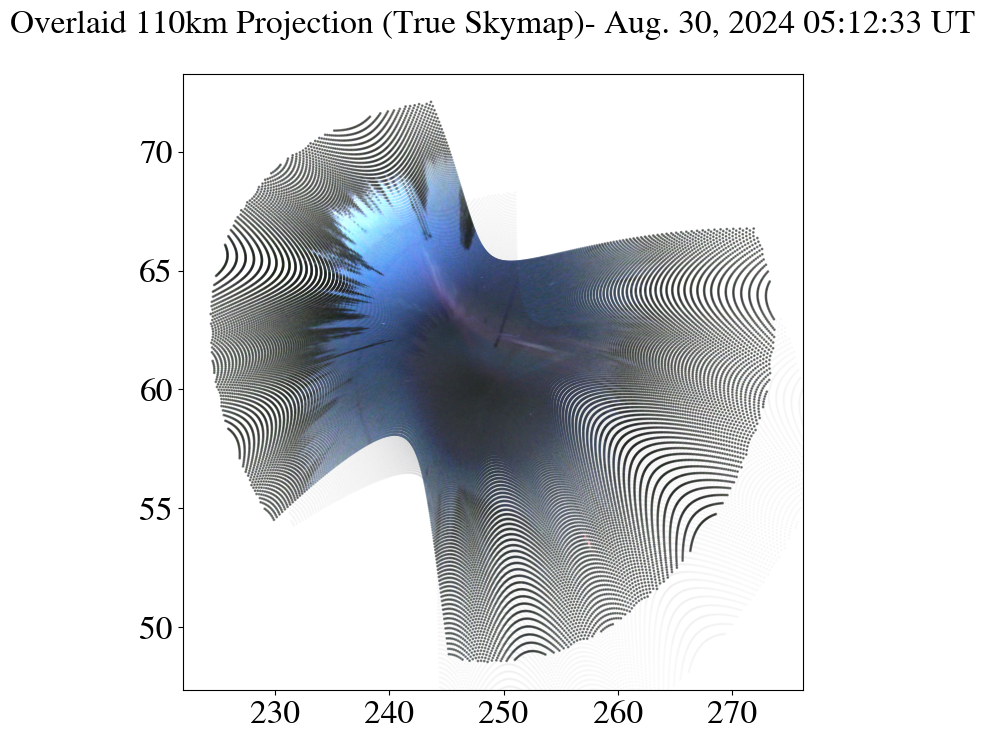

In [99]:
time_index = 251 # look at 5:10 UTC

R_yknf = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_yknf = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_yknf = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values

R_fsmi = fsmi_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
G_fsmi = fsmi_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
B_fsmi = fsmi_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values


# Extract time and format it
raw_time = yknf_rgb_asi_ds.times.values[time_index]
time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")

site_name_yknf = "Yellowknife" 
site_name_fsmi = "Fort Smith" 

# contrast adjustment: alpha=contrast, beta=brightness
alpha = 5
beta = 5
rgb_yknf = np.stack([R_yknf, G_yknf, B_yknf], axis=-1)  # shape: (x, y, 3)
rgb_fsmi = np.stack([R_fsmi, G_fsmi, B_fsmi], axis=-1)  # shape: (x, y, 3)

rgb_yknf_adjusted = cv2.convertScaleAbs(rgb_yknf, alpha=alpha, beta=beta)
rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb_fsmi, alpha=alpha, beta=beta)

# 110km overlaid (given projection)
yknf_lat_110_arr = np.array(yknf_rgb_asi_ds["lat_110"])
yknf_lon_110_arr = np.array(yknf_rgb_asi_ds["lon_110"])
fsmi_lat_110_arr = np.array(fsmi_rgb_asi_ds["lat_110"])
fsmi_lon_110_arr = np.array(fsmi_rgb_asi_ds["lon_110"])

plt.figure(figsize=(8,8))
plt.scatter(yknf_lon_110_arr.flatten(),yknf_lat_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=0.5)
plt.scatter(fsmi_lon_110_arr.flatten(),fsmi_lat_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.02)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
plt.title(f"Overlaid 110km Projection (True Skymap)- {time_str}", pad=30)
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"Original Skymap {site_name_yknf} – {time_str}", pad=30);
plt.show()


# # 110km overlaid (my projection)
# plt.figure(figsize=(8,8))
# plt.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=1)
# plt.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.3)
# plt.xlabel("Longitude (deg)")
# plt.ylabel("Latitude (deg)")
# plt.title("Overlaid 110km Projection - {time_str}", pad=30)
# plt.xlim(ax_skymap.get_xlim())
# plt.ylim(ax_skymap.get_ylim())
# plt.show()


**Meeting Notes 10/21:**
1. don't expect steve to move too much in altitude, just in lat --> as we are moving through the frames
2. eventually (try to work on it this week before the next meeting) -- algorithm for any given timestep, calculate what algo thinks is most lilkely altitude, (see how stable it is to loop through all of them, see how reasonable the calculated altitudes are based on lit)
3. claire is going to reach out to a person from the conference to ask about their work on starmaps to see if we should try to implement that
   - we are gonna do it if there is already simple enough, have some boilerplate to work wtih
4. more complicated approach -- 1 or several cuts thru image/steve, plot of intensity 
   - intesnity as function along the cut, passing through the same latitudes and longitudes for the yknf and fmsi imagery --> plot intensity along the cut
   - what altitude when projected to, gives the most similar plots (to get optimal altitude at the center of the plots, not the extension, so just when STEVE is brightest ie the plot of the intensity reaches some maximum)

**Todo this week:**
1. finish debugging the projection --> look at the individual pixels
2. get the algorithm working 

### Algorithm
**GOAL**: for any given timestep, calculate the most likely altitude 

**STEPS**:
1. Load in all the necessary data for the project_lat_lon() function
2. For each frame in each minute, in each hour, in each day (maybe make less granular with some averaging):
3. --- For each altitude in h_target_arr:
4. --- ---Apply the project_lat_lon() function to YKNF and FSMI data, each
5. --- --- Get the overlaid plots of YKNF and FSMI el/az projected to h_target, (create a function to get these overlaid and individual plots, and save them to a separate folder, per altitude, per timestep --> diff folder per altitude)
6. --- --- Given these overlaid plots, calculate how much they are not lining up (numerical quantity like fraction of overlapping pixels + the nearest-neighbor mean distance (m), or use the intensity plot method in archer and like claire was mentioning)
7. --- Given this lineup quantification for each of the projections to h_target for all h_target in h_target_arr, make some conclusion about what the most likely elevation is 
8. --- altitude_preds: Save the most likely h_arr to some (pixel row, pixel col) shaped-array, to represent most likely height calculated for each pixel 
9. Do some averaging / counting of the most frequently appearing projected height in altitude_preds to output the most probable altitude 

**PARAMETERS**:
1. yknf_az_arr = array of azimuths for each pixel in yknf
3. fsmi_az_arr = array of azimuths for each pixel in fsmi
4. yknf_el_arr = array of elevations for each pixel in yknf
5. fsmi_az_arr = array of elevations for each pixel in fsmi
6. yknf_lat = latitude of yknf camera
7. fsmi_lat = latitude of fsmi camera
8. fsmi_lon = longitude of yknf camera 
9. fsmi_lon = longitude of fsmi camera
    - can get these from the xarrays that we pass in

**REVISED PARAMETERS**
1. yknf_rgb_asi_ds (xarray)
2. fsmi_rgb_asi_ds (xarray)
3. date (datetime(2024,8,30))
4. hour (int)
5. h_target_arr = array of altitudes to project to 

**OUTPUTS**:
1. the most likely altitude (averaged over all the altitude calculations, or another method of looking at it)
2. altitude_preds = array of most likely altitudes per pixel
3. some plots (?)
    - maybe save all of the overlaid plots for reference into a folder
    - output to console the overlaid maps for just a few frames 
    - try some averaged frames?

**NEED TO FIGURE OUT**:
1. how to quantify the difference / similarity between the overlaps in the overlaid lat/long images for the YKNF and FSMI images
   - look at archer paper + what claire mentioned --> the intensity arcs? 
   - nearest neighbor distance / cv type stuff? 
2. how to do the averaging of the predicted altitudes so that the algorithm outputs one guess as to the altitude that the aurora is at for some set of timestamps?
3. how to restrict the outlier values for my projected skymaps?
   - already tried to get match the NaNs indices from the ground truth projected skymaps
   - look into how the skymap .sav actually does the masking --> need to look at some metadata for the skymaps
   - need to look into each pixel specifically to see what is going on 

In [ ]:
def project_lat_lon(az_arr, el_arr, lat_camera, lon_camera, h, skymap_110_mask):
    '''
    Projected the azimuth and elevation arrays to the specified height.
    
    Parameters: 
        az_arr = 2D azimuth array for each pixel (NaNs ok, degrees, xarray)
        el_arr = 2D elevation array for each pixel (NaNs ok, degrees, xarray, no need to be filtered)
        lat_camera = latitude of camera (degrees) --> shape [480, 553]
        lon_camera = longitude of camera (degrees) --> shape [480, 553]
        h = height you want to project azimuth and elevation to to get latitude and longitude for each pixel
        skymap_110_mask = mask for where the latitude and longitude are NaNs in the ground truth lat110 and lon110 projections

    Outputs:
        lat_aurora_arr = latitudes of the aurora projected to given height h
        lon_aurora_arr = longitudes of the aurora project to give height h 
    '''

    # convert to radians + applying mask 
    el_arr = np.radians(np.array(el_arr))
    az_arr = np.radians(np.array(az_arr))
    
    # create elevation mask (True when valid)
    el_mask = (el_arr > np.radians(5)) & (el_arr < np.radians(90))
    
    # combine with skymap mask: True = valid pixel
    valid_mask = el_mask & (~skymap_110_mask)
    
    # set invalid pixels to NaN
    el_arr[~valid_mask] = np.nan
        
    # horizontal distance between camera and aurora along camera's tangent plane
    d1_arr = h / np.tan(el_arr)

    # decompose horizontal distance into east and north components relative to camera tan plane
    dx_arr = d1_arr * np.sin(az_arr)
    dy_arr = d1_arr * np.cos(az_arr)

    # convert N/E offset components to (lat, lon) --> comes out in decimal degrees 
    lat_delta_arr = dy_arr / 111045 #degrees
    lon_delta_arr = dx_arr / (np.cos(np.radians(lat_camera + lat_delta_arr)) * 111321) 

    # add lat/long offset to camera's og lat/lon to get the lat/lon of the aurora at the chosen height!
    lat_aurora_arr = lat_camera + lat_delta_arr
    lon_aurora_arr = lon_camera + lon_delta_arr

    # apply the same mask again just in case 
    lat_aurora_arr[skymap_110_mask] = np.nan
    lon_aurora_arr[skymap_110_mask] = np.nan

    return lat_aurora_arr, lon_aurora_arr

In [111]:
yknf_lat_110_proj, yknf_lon_110_proj = project_lat_lon(full_azimuth_yknf, 
                                                     full_elevation_yknf, 
                                                     lat_yknf, 
                                                     lon_yknf, 
                                                     h_target, 
                                                     yknf_110_mask)

fsmi_lat_110_proj, fsmi_lon_110_proj = project_lat_lon(full_azimuth_fsmi, 
                                                     full_elevation_fsmi, 
                                                     lat_fsmi, 
                                                     lon_fsmi, 
                                                     h_target, 
                                                     fsmi_110_mask)


In [122]:
def plot_lat_lon(yknf_rgb_asi_ds, fsmi_rgb_asi_ds, time_index, site_name_yknf, site_name_fsmi, yknf_lat, yknf_lon, fsmi_lat, fsmi_lon):
    ''' 
    Plots the projected latitude and longitude of the YKNF and FSMI, and overlays them. 
    Produces 3 plots total: YKNF, FSMI, overlaid, and saves each of the images. 

    Parameters:
        yknf_rgb_asi_ds: xarray of the yknf skymap <xarray>
        fsmi_rgb_asi_ds: xarray of the fsmi skymap <xarray>
        time_index: specific frame we are looking at from the asi ds <int>
        site_name_yknf: string to label the plots
        site_name_fsmi: string to label the plots
        yknf_lat: projected latitude array of one yknf frame <2d arr>
        yknf_lon: projected longitude array of one yknf frame <2d arr>
        fsmi_lat: projected latitude array of one fsmi frame <2d arr>
        fsmi_lon: projected longitude array of one fsmi frame <2d arr>
        h_target: height that yknf & fsmi frames were projected to <int>
        lat_lon_plots: folder to save the 3 images to 

    Outputs:
        3 plots of the YKNF, FSMI, overlaid latitude and longitude
    '''    
    
    R_yknf = yknf_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
    G_yknf = yknf_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
    B_yknf = yknf_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
    
    R_fsmi = fsmi_rgb_asi_ds.image.sel(channel="R").isel(times=time_index).values
    G_fsmi = fsmi_rgb_asi_ds.image.sel(channel="G").isel(times=time_index).values
    B_fsmi = fsmi_rgb_asi_ds.image.sel(channel="B").isel(times=time_index).values
    
    
    # Extract time and format it
    raw_time = yknf_rgb_asi_ds.times.values[time_index]
    time_obj = pd.to_datetime(raw_time.decode("utf-8").replace(" UTC", ""))
    time_str = time_obj.strftime("%b. %d, %Y %H:%M:%S UT")
        
    # contrast adjustment: alpha=contrast, beta=brightness
    alpha = 5
    beta = 5
    rgb_yknf = np.stack([R_yknf, G_yknf, B_yknf], axis=-1)  # shape: (x, y, 3)
    rgb_fsmi = np.stack([R_fsmi, G_fsmi, B_fsmi], axis=-1)  # shape: (x, y, 3)
    
    rgb_yknf_adjusted = cv2.convertScaleAbs(rgb_yknf, alpha=alpha, beta=beta)
    rgb_fsmi_adjusted = cv2.convertScaleAbs(rgb_fsmi, alpha=alpha, beta=beta)
    
    # yknf projected
    fig1, ax1 = plt.subplots(figsize=(8,8))
    scat1 = ax1.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
    plt.xlim(ax_skymap.get_xlim())
    plt.ylim(ax_skymap.get_ylim())
    ax1.set_ylabel("Latitude (deg)")
    ax1.set_xlabel("Longitude (deg)")
    ax1.set_title(f"110km Projection: {site_name_yknf} – {time_str}", pad=30);
    plt.show()
    
    # fsmi projected
    fig2, ax2 = plt.subplots(figsize=(8,8))
    scat2 = ax2.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1)
    plt.xlim(ax_skymap.get_xlim())
    plt.ylim(ax_skymap.get_ylim())
    ax2.set_ylabel("Latitude (deg)")
    ax2.set_xlabel("Longitude (deg)")
    ax2.set_title(f"110km Projection: {site_name_fsmi} – {time_str}", pad=30);
    plt.show()
    
    # 110km  overlaid --> 
    plt.figure(figsize=(8,8))
    plt.scatter(yknf_lon.flatten(),yknf_lat.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1, alpha=0.5)
    plt.scatter(fsmi_lon.flatten(),fsmi_lat.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1, alpha=0.02)
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")
    plt.title(f"Overlaid {h_target}km Projection - {time_str}", pad=30)
    plt.xlim(ax_skymap.get_xlim())
    plt.ylim(ax_skymap.get_ylim())
    plt.show()

    return rgb_yknf_adjusted, rgb_fsmi_adjusted


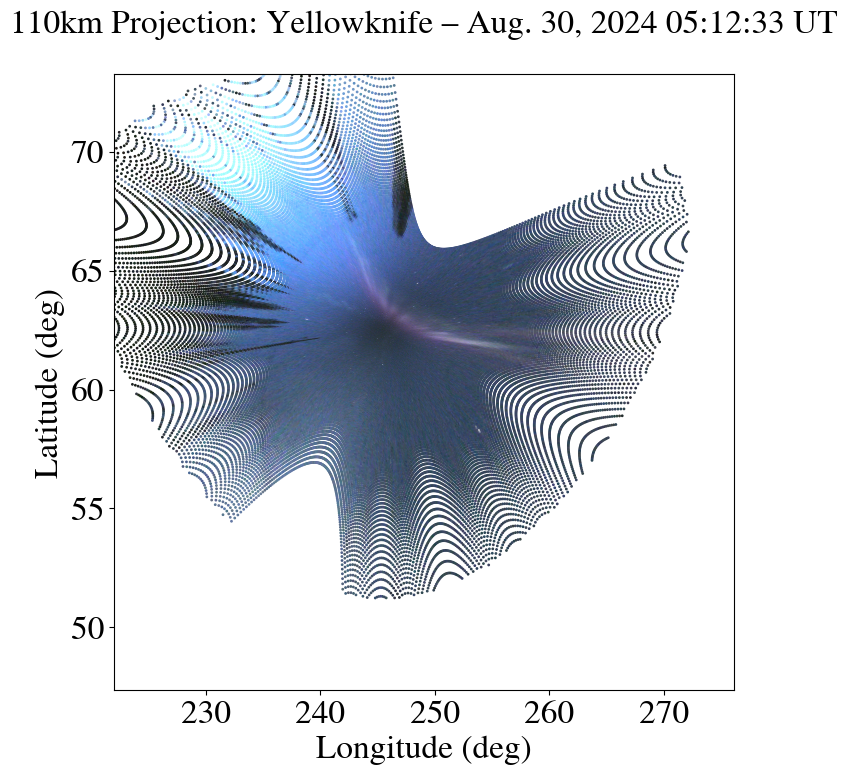

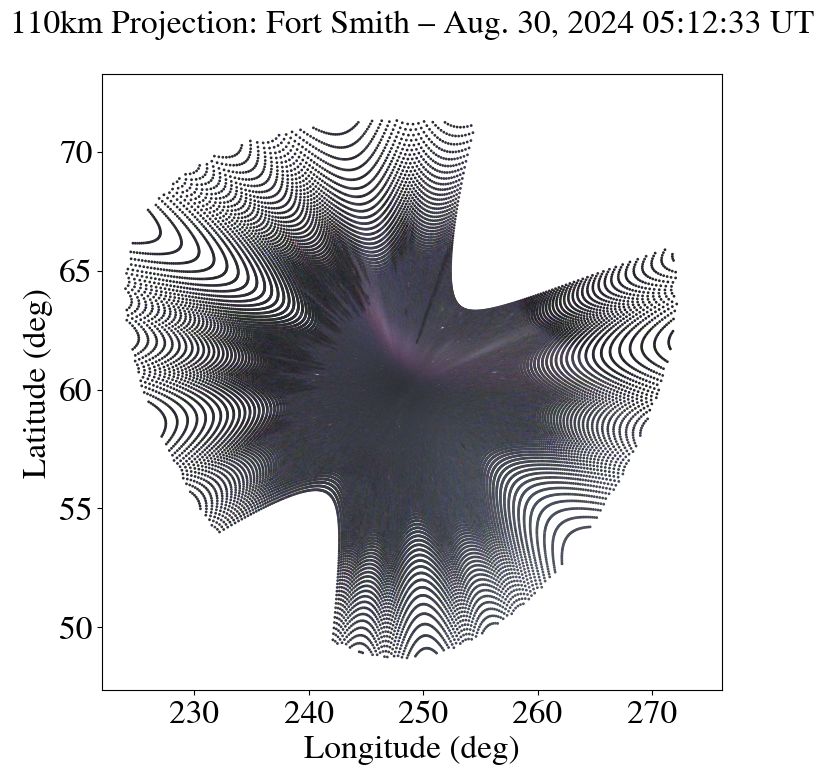

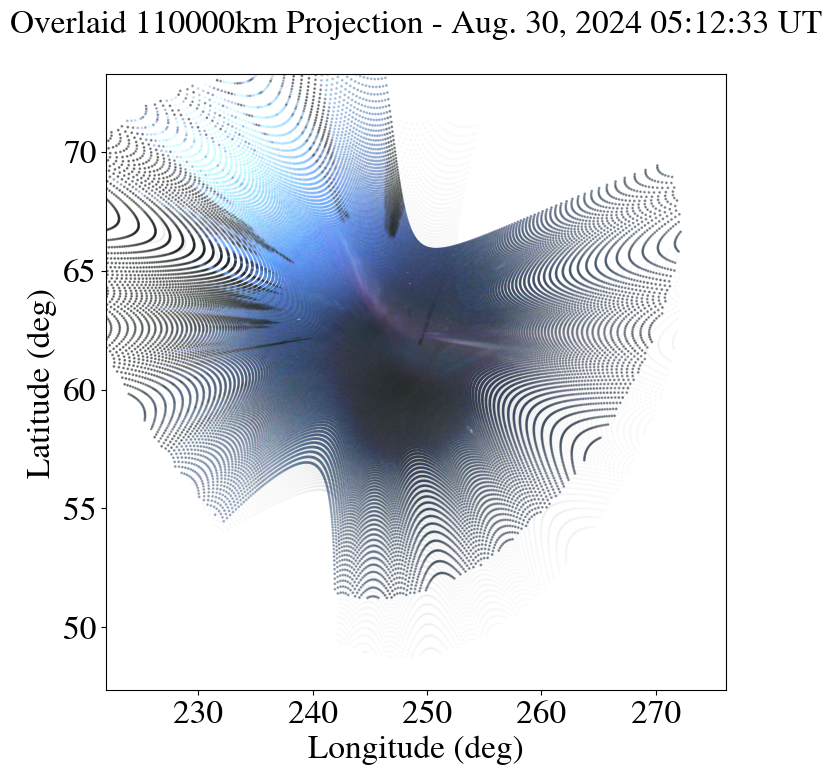

In [123]:
yknf_rgb, fsmi_rgb = plot_lat_lon(yknf_rgb_asi_ds, 
                                 fsmi_rgb_asi_ds, 
                                 time_index, 
                                 site_name_yknf, 
                                 site_name_fsmi, 
                                 yknf_lat_110_proj, 
                                 yknf_lon_110_proj, 
                                 fsmi_lat_110_proj, 
                                 fsmi_lon_110_proj)

### Steps for alignment calcs -- using intensity profiles 
0. assumed that the same frame from YKNF and FSMI have been projected to the same height, and we have the latitude and longitude arrays for each of them  
1. masking
   - need to do some masking / greyscaling w/ thresholds so that the lighter pixels in the nightsky dont get confused with the pixels of the auroral feature
   - this threshold needs to be adaptable to the different colors of aurora, to acc for the green / purple / etc other flows
   - "discarding" pixels in the sky that are not our target auroral feature
   - most basic (to start with): manually set a threshold for pixels, remove all pixels that fall outside of the threshold
2. average the auroral pixels along longitude to get an intensity vs latitude curve (as in archer)
   - x = latitude
   - y = aurora intensity, based on how bright the pixel is
3. correlation between the intensity curves
4. 
   - for 2 curves at a h1, if their correlation is higher than 2 curves at h2, then h1 is the best estimate for the true altitude of the auroral feature

In [126]:
def calculate_intensity_corr(yknf_lat, yknf_lon, fsmi_lat, fsmi_lon, yknf_rgb, fsmi_rgb):
    '''
    Collapse the projected lat/lon images along a longitude for a specific site / timestamp 
    so can get the correlation between intensity-latitude curve for YKNf and FSMI at a certain height 

    Parameters:
        yknf_lat: projected latitude array of one yknf frame <2d arr>
        yknf_lon: projected longitude array of one yknf frame <2d arr>
        fsmi_lat: projected latitude array of one fsmi frame <2d arr>
        fsmi_lon: projected longitude array of one fsmi frame <2d arr>
        yknf_rgb: rgb array of the pixel intensities for YKNF
        fsmi_rgb: rbg array of the pixel intensities for FSMI

    Outputs:
        Plots the 2 intensity-latitude lines for YKNF, FSMI 
        intensity_corr: correlation between the 2 plots 
        
        
    '''

    ### MASKING 
    # grey scale conversion w/ standard opencv weights 
    yknf_greyed = np.dot(yknf_rgb[..., :3], [0.2989, 0.5870, 0.1140]).flatten() # need to flatten for percentile calcs
    intensity_threshold = np.percentile(yknf_greyed, 95) # get 95% percentile of pixel values for the threshold
    yknf_mask = yknf_greyed >= intensity_threshold
    yknf_lat_masked = yknf_lat[yknf_mask]
    yknf_lon_masked = yknf_lon[yknf_mask]
    yknf_rgb_masked = yknf_rgb[yknf_mask]

    fsmi_greyed = np.dot(fsmi_rgb[..., :3], [0.2989, 0.5870, 0.1140]).flatten()
    intensity_threshold = np.percentile(fsmi_greyed, 95) # get 95% percentile of pixel values for the threshold
    fsmi_mask = fsmi_greyed >= intensity_threshold
    fsmi_lat_masked = fsmi_lat[fsmi_mask]
    fsmi_lon_masked = fsmi_lon[fsmi_mask]
    fsmi_rgb_masked = fsmi_rgb[fsmi_mask]

    return yknf_lat_masked, yknf_lon_masked, yknf_rgb_masked, fsmi_lat_masked, fsmi_lon_masked, fsmi_rgb_masked

    
    


In [127]:
yknf_lat_masked, yknf_lon_masked, yknf_rgb_masked, fsmi_lat_masked, fsmi_lon_masked, fsmi_rgb_masked = calculate_intensity_corr(yknf_lat_110_proj, 
                                                                                                                             yknf_lon_110_proj, 
                                                                                                                             fsmi_lat_110_proj, 
                                                                                                                             fsmi_lon_110_proj,
                                                                                                                             yknf_rgb,
                                                                                                                             fsmi_rgb
                                                                                                                               )

fig1, ax1 = plt.subplots(figsize=(8,8))
scat1 = ax1.scatter(yknf_lon_proj_110_arr.flatten(),yknf_lat_proj_110_arr.flatten(),c=rgb_yknf_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax1.set_ylabel("Latitude (deg)")
ax1.set_xlabel("Longitude (deg)")
ax1.set_title(f"110km Projection: {site_name_yknf} – {time_str}", pad=30);
plt.show()

# fsmi projected
fig2, ax2 = plt.subplots(figsize=(8,8))
scat2 = ax2.scatter(fsmi_lon_proj_110_arr.flatten(),fsmi_lat_proj_110_arr.flatten(),c=rgb_fsmi_adjusted.reshape(-1, 3)/256,s=1)
plt.xlim(ax_skymap.get_xlim())
plt.ylim(ax_skymap.get_ylim())
ax2.set_ylabel("Latitude (deg)")
ax2.set_xlabel("Longitude (deg)")
ax2.set_title(f"110km Projection: {site_name_fsmi} – {time_str}", pad=30);
plt.show()


IndexError: boolean index did not match indexed array along dimension 0; dimension is 480 but corresponding boolean dimension is 265440

10/29 Meeting Notes:

1. 2 different ways of calculating some metric for how well the auroras are lining up:
    1. doing interpolation so that the overlapping areas for one YKNF and one FSMI frames are in the same latitude and longitude grid, then calculating the correlations between each of the corresponding pixels to see how they are lining up
    2. taking vertical slices in longitude for each of the regions in the YKNF and in the FSMI frames, fit gaussians to the brightness of each pixel in the slice
       - the peak of the gaussian is the brightest pixel in the vertical slice is, record the lat and lon that that pixel occurs at
       - repeat this for all the slices across YKNF and FSMI frames, then fit a line to all of these recorded (lat, lon) of brightest pixels
       - calculate how different the lines are in slope and in vetical distance from eachother
       - this works bc theoretically, STEVE should be a straight phenomenon, hence fitting a straight line to it
2. the algorithm should be as robust as possible across all of the different frames, and altitudes 
   - maybe a little different from hr 5 vs hr10 bc looking at very different things, but overall try to make it as robust as possible 

Starmaps:
- the german guy is working on it and claire will keep me in the loop
- can replace my altitude calcs bc we can prob trust it more once he is done, then its more crucial for me to get the part of the mechanism that compares how well the auroras features are lining up working 

Misc:
- try out my keycard and let claire know
- if i dont get paid by next week tell claire 